In [3]:
# 1. 데이터 합치기 + 기본 전처리

import pandas as pd

# 엑셀 → 하나의 DataFrame으로 합치기
paths = [
    "../data/odor_normal.xlsx",
    "../data/odor_fragrance.xlsx",
    "../data/odor_smoke.xlsx",
]

dfs = [pd.read_excel(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

# 컬럼 확인
print(df.head())
print(df['label'].value_counts())

# 타임스탬프를 초 단위로 정규화 (옵션)
df = df.sort_values('timestamp_ms')
df['time_s'] = (df['timestamp_ms'] - df['timestamp_ms'].min()) / 1000.0

# 사용할 피처 선택
feature_cols = ['temp', 'hum', 'pres', 'gas_kohm']
X = df[feature_cols].copy()
y = df['label'].copy()


   timestamp_ms   temp    hum     pres  gas_kohm   label
0        113493  21.04  21.13  1026.04     27.29  normal
1        114902  20.87  21.07  1026.03     34.15  normal
2        116311  20.77  20.98  1026.02     40.35  normal
3        117720  20.72  20.89  1026.02     45.71  normal
4        119129  20.69  20.80  1026.02     51.21  normal
label
fragrance    512
normal       448
smoke        448
Name: count, dtype: int64


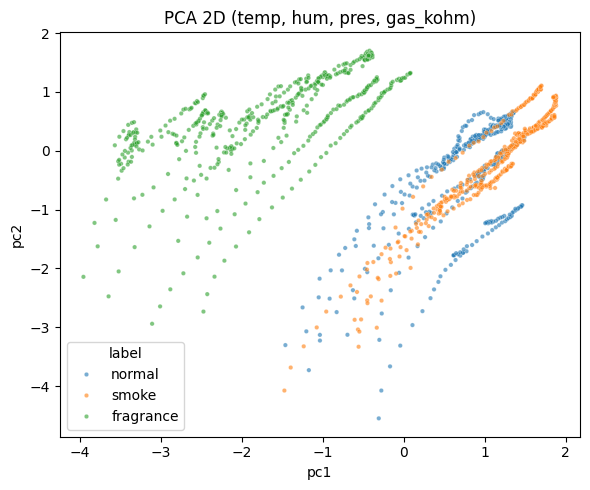

PCA 설명 분산: [0.53968873 0.2387567 ]


In [4]:
# 2. 스케일링 + PCA/UMAP 시각화, K-Means 클러스터링
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['pc1','pc2'])
pca_df['label'] = y.values

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue='label', s=10, alpha=0.6)
plt.title('PCA 2D (temp, hum, pres, gas_kohm)')
plt.tight_layout()
plt.show()

print('PCA 설명 분산:', pca.explained_variance_ratio_)


/Users/marina/Desktop/PuriPilot/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


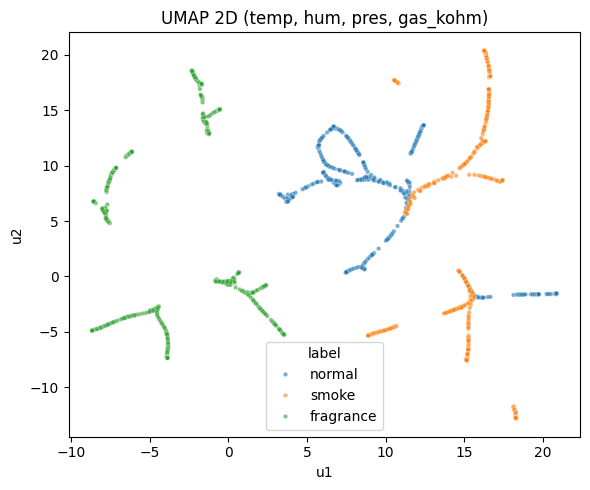

In [6]:
# UMAP
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

umap_df = pd.DataFrame(X_umap, columns=['u1','u2'])
umap_df['label'] = y.values

plt.figure(figsize=(6,5))
sns.scatterplot(data=umap_df, x='u1', y='u2', hue='label', s=10, alpha=0.6)
plt.title('UMAP 2D (temp, hum, pres, gas_kohm)')
plt.tight_layout()
plt.show()

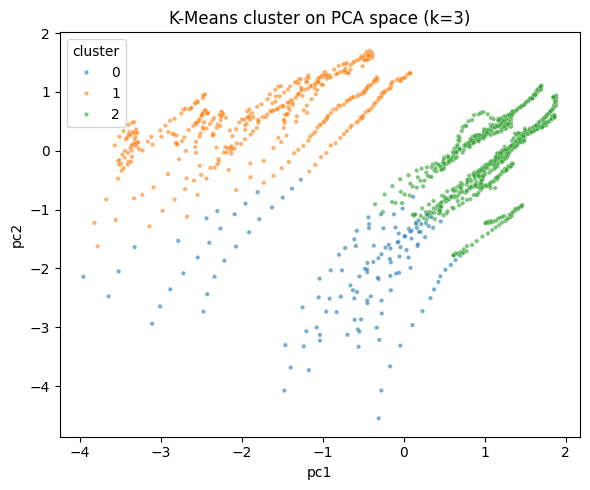

cluster     0    1    2
label                  
fragrance  28  484    0
normal     56    0  392
smoke      56    0  392


In [7]:
# K-Means로 “냄새 3클러스터”가 자연스럽게 나뉘는지:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

pca_df['cluster'] = clusters

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue='cluster', palette='tab10', s=10, alpha=0.6)
plt.title('K-Means cluster on PCA space (k=3)')
plt.tight_layout()
plt.show()

print(pd.crosstab(pca_df['label'], pca_df['cluster']))

In [8]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, clusters)  # clusters는 kmeans에 할당된 라벨
print(f"Silhouette score: {score:.3f}")

Silhouette score: 0.472


In [ ]:
# 3. 분류 모델 학습 (SVM, RF, XGBoost)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)  # normal/fragrance/smoke → 0/1/2

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

RandomForest
               precision    recall  f1-score   support

   fragrance       1.00      1.00      1.00       102
      normal       1.00      0.99      0.99        90
       smoke       0.99      1.00      0.99        90

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



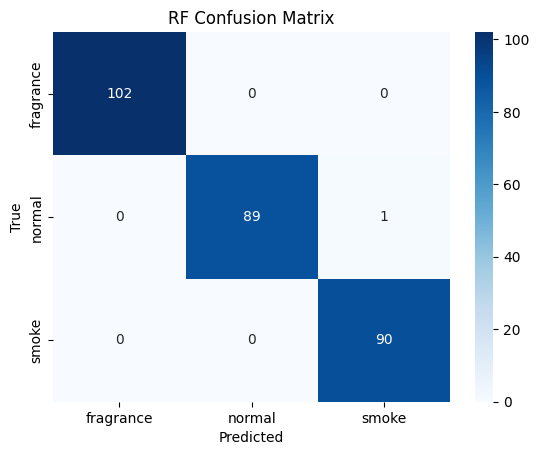

temp: 0.198
hum: 0.137
pres: 0.566
gas_kohm: 0.099


In [11]:
# Random Forest:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("RandomForest\n", classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('RF Confusion Matrix')
plt.show()

# 중요도 확인
for name, imp in zip(feature_cols, rf.feature_importances_):
    print(f'{name}: {imp:.3f}')


In [12]:
# SVM:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=5, gamma='scale', probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM\n", classification_report(y_test, y_pred, target_names=le.classes_))

SVM
               precision    recall  f1-score   support

   fragrance       1.00      1.00      1.00       102
      normal       1.00      0.99      0.99        90
       smoke       0.99      1.00      0.99        90

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



In [13]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=3,
    random_state=42
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("XGBoost\n", classification_report(y_test, y_pred, target_names=le.classes_))

XGBoost
               precision    recall  f1-score   support

   fragrance       1.00      1.00      1.00       102
      normal       1.00      0.99      0.99        90
       smoke       0.99      1.00      0.99        90

    accuracy                           1.00       282
   macro avg       1.00      1.00      1.00       282
weighted avg       1.00      1.00      1.00       282



In [ ]:
# 모델/스케일러/라벨인코더 저장:
# 실제 배포(ESP32 실시간 inference)는 아래처럼 갈 것임.
# 1. Edge Impulse에 데이터 업로드
# 2. Studio에서 임펄스 설계 + 학습
# 3. C++ library로 내보내서 ESP32에 포함

import joblib
joblib.dump(rf, 'odor_rf_model.pkl')
joblib.dump(scaler, 'odor_scaler.pkl')
joblib.dump(le, 'odor_label_encoder.pkl')

['odor_label_encoder.pkl']